<a href="https://colab.research.google.com/github/g-nightingale/ML_algorithms/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Vanilla RNN from scratch <br>
Author: Geoff Nightingale <br>
Date: 13/05/2020 <br>
Useful links:
- https://github.com/Kulbear/deep-learning-coursera/blob/master/Sequence%20Models/Building%20a%20Recurrent%20Neural%20Network%20-%20Step%20by%20Step%20-%20v2.ipynb
- https://www.coursera.org/learn/nlp-sequence-models/discussions/weeks/1/threads/Ma0W1RBdEeiM0AqkY8EcsA

### RNN Training Process Overview
- Parameter initialisation
  - Optimisation Loop
      - Forward Pass
          - For each time step
              - Calculation activation at timestep t
              - Cache predictions and activations
              - Accumulate losses: losses += (y hat - y)^2
      - Backwards Pass
          - Retrieve cache and parameters
          - Set gradients to zero
          - For each time step
              - Calculate gradients
              - Update gradients
      - Update parameters
          - weight = weight + lr * partial derivatives


In [0]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [0]:
# Checking some calculations

m = 5
n_x = 1
n_y = 1
n_a = 3
T_x = 10

xt = np.random.randn(n_x, m)
a_prev = np.random.randn(n_a, m)

Wax = np.random.randn(n_a, n_x)
Waa = np.random.randn(n_a, n_a)
Wya = np.random.randn(n_y, n_a)
ba = np.random.randn(n_a, 1)
by = np.random.randn(n_y, 1)

parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}


In [0]:
# Checking activation function calculation
# (3 x 1)(1 x m) + (3 x 3)(3 x m) + (3 x m)
z = np.dot(Wax,xt) + np.dot(Waa,a_prev) + ba
z

array([[ 0.03065724, -3.53228177, -1.46182393,  2.62110229, -1.55468261],
       [ 0.52983398, -1.1442116 , -0.91852593,  0.23194035, -0.16251721],
       [-2.62050306, -4.02546569, -1.70330561, -2.25055972, -3.71182833]])

In [0]:
# Verifying tanh function
c = -0.04859525
tanh_gn = (np.exp(c) - np.exp(-c))/(np.exp(c) + np.exp(-c))
tanh_gn

-0.04855703356502644

# New Method

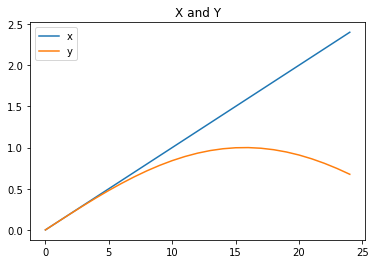

In [0]:
X = np.array([x/10.0 for x in range(25)])
Y = np.sin(X)

plt.figure()
plt.title('X and Y')
plt.plot(X, label='x')
plt.plot(Y, label='y')
plt.legend()
plt.show()

In [0]:
### New codes

In [0]:
def initialize_parameters(n_a, n_x, n_y):
    """
    Initialize parameters with small random values
    
    Returns:
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    """
    np.random.seed(1)
    Wax = np.random.randn(n_a, n_x)*0.01 # input to hidden
    Waa = np.random.randn(n_a, n_a)*0.01 # hidden to hidden
    Wya = np.random.randn(n_y, n_a)*0.01 # hidden to output
    b = np.zeros((n_a, 1)) # hidden bias
    by = np.zeros((n_y, 1)) # output bias
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b,"by": by}
    
    return parameters


In [0]:
def rnn_step_forward(parameters, a_prev, x):
    
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    a_next = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b) # hidden state
    p_t = np.dot(Wya, a_next) + by
    #p_t = softmax(np.dot(Wya, a_next) + by) # unnormalized log probabilities for next chars # probabilities for next chars 
    
    return a_next, p_t

In [0]:
def rnn_step_backward(dy, gradients, parameters, x, a, a_prev):

    gradients['dWya'] += np.dot(dy, a.T)

    if dy.ndim == 1:
        dy_sum = np.sum(dy)
    else:
        dy_sum = np.sum(dy, axis=1, keepdims=True)

    gradients['dby'] += dy_sum
    da = np.dot(parameters['Wya'].T, dy_sum) + gradients['da_next'] # backprop into h
    daraw = (1 - a ** 2) * da
 
    # print('daraw', daraw.shape)
    # print('x', x.shape)

    # daraw_og = (1 - a * a) * da 
    # daraw_new = np.dot(da, (1 - a * a))
    # print('daraw_og', daraw_og)
    # print('daraw_new', daraw_new)
    # print('grads', gradients['db'] += daraw_wtf)

    gradients['db'] += np.sum(daraw, axis=1, keepdims=True)
    gradients['dWax'] += np.dot(daraw, x.T)
    gradients['dWaa'] += np.dot(daraw, a_prev.T)
    gradients['da_next'] = np.dot(parameters['Waa'].T, daraw)

    return gradients

In [0]:
def update_parameters(parameters, gradients, lr, print_grad_updates=False):

    if print_grad_updates is True:
        print('Wax before', parameters['Wax'])
        print('Waa before', parameters['Waa'])
        print('Wya before', parameters['Wya'])
        print('b before', parameters['b'])
        print('by before', parameters['by'], '\n')

        print('dWax', gradients['dWax'])
        print('dWaa', gradients['dWaa'])
        print('dWya', gradients['dWya'])
        print('db', gradients['db'])
        print('dby', gradients['dby'], '\n')

    parameters['Wax'] += -lr * gradients['dWax']
    parameters['Waa'] += -lr * gradients['dWaa']
    parameters['Wya'] += -lr * gradients['dWya']
    parameters['b']  += -lr * gradients['db']
    parameters['by']  += -lr * gradients['dby']

    if print_grad_updates is True:
        print('Wax after', parameters['Wax'])
        print('Waa after', parameters['Waa'])
        print('Wya after', parameters['Wya'])
        print('b after', parameters['b'])
        print('by after', parameters['by'], '\n')

    return parameters

In [0]:
def rnn_forward(X, Y, a0, parameters):
    
    # Initialize x, a and y_hat as empty dictionaries
    x, a, y_hat = {}, {}, {}
    
    a[-1] = np.copy(a0)
    
    # initialize your loss to 0
    loss = 0
    
    for t in range(len(X)):

        # Run one step forward of the RNN
        # TODO: adjust for varying m
        if X.ndim == 1:
            x = X[t]
        else:
            x = X[t].reshape((1, X.shape[1]))

        a[t], y_hat[t] = rnn_step_forward(parameters, a[t-1], x)

        #print(y_hat[t], Y[t])
        
        # Update the loss by substracting the cross-entropy term of this time-step from it.
        #loss -= np.log(y_hat[t][Y[t],0])
        # Using sqaured error in place of cross entropy

        loss += np.sum((y_hat[t] - Y[t])**2)
        # print('x', x)
        # print('y_hat', y_hat)
        # print('y', Y)       
        # print(stop)

    cache = (y_hat, a, x)
    
    return loss, cache


In [0]:
def clip(gradients, maxValue):
    """
    Clips the gradients' values between minimum and maximum.
    
    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue -- everything above this number is set to this number, and everything less than -maxValue is set to -maxValue
    
    Returns: 
    gradients -- a dictionary with the clipped gradients.
    """
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
   
    ### START CODE HERE ###
    # clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]. (≈2 lines)
    for gradient in [dWax, dWaa, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue, out = gradient)
    ### END CODE HERE ###
    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

In [0]:
def rnn_backward(X, Y, parameters, cache):
    # Initialize gradients as an empty dictionary
    gradients = {}
    
    # Retrieve from cache and parameters
    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    
    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(b), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])

    ### START CODE HERE ###
    # Backpropagate through time
    for t in reversed(range(len(X))):
        dy = y_hat[t] - Y[t]
        #dy[Y[t]] -= 1

        if X.ndim == 1:
            x = X[t]
        else:
            x = X[t].reshape((1, X.shape[1]))

        gradients = rnn_step_backward(dy, gradients, parameters, x, a[t], a[t-1])
    ### END CODE HERE ###
    
    return gradients, a    


In [0]:
def optimize(X, Y, a_prev, parameters, learning_rate=0.01, grad_max=100, print_grad_updates=False):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """
    
    ### START CODE HERE ###
    
    # Forward propagate through time (≈1 line)
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    # Backpropagate through time (≈1 line)
    gradients, a = rnn_backward(X, Y, parameters, cache)

    # Clip your gradients between -5 (min) and 5 (max) (≈1 line)
    gradients = clip(gradients, grad_max)
    
    # Update parameters (≈1 line)
    parameters = update_parameters(parameters, gradients, learning_rate, print_grad_updates=print_grad_updates)
    
    ### END CODE HERE ###
    
    return loss, gradients, a[len(X)-1]

In [0]:
def model(X, Y, num_iterations=10, n_a=3, learning_rate=0.01, print_chart=False, grad_max=100, print_grad_updates=False, update_n=1000):
    """
    Trains the model and generates dinosaur names. 
    
    Arguments:  
    data -- text corpus
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text, size of the vocabulary
    
    Returns:
    parameters -- learned parameters
    """
    
    # Retrieve n_x and n_y from vocab_size
    if X.ndim == 1:
        m = 1
    else:
      m = X.shape[1] # Training examples
    n_x = 1
    n_y = 1

    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, m))

    # Optimization loop
    for j in range(num_iterations):
        
        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        #curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate=0.01)
        loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate=learning_rate, grad_max=grad_max, print_grad_updates=print_grad_updates)     
        ### END CODE HERE ###

        # if j<=2:
        #     print('gradients: iteration', j, '\n', gradients, '\n')

        # Every Z iterations, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % update_n == 0:
            print('Iteration: %d, Loss: %f' % (j, loss))
            # print('parameters', '\n', parameters)
            # print('final gradients', '\n', gradients, '\n')

    # Print chart of actual vs expected
    if print_chart is True:
        print()
        if X.ndim == 1:
          loss, cache = rnn_forward(X, Y, a_prev, parameters)
        else:
          loss, cache = rnn_forward(X[:, 0], Y[:, 0], a_prev, parameters)

        preds = []
        for l in range(len(cache[0])):
          preds.append(cache[0][l][0][0])

        plt.title('Actual vs Expected')
        if X.ndim == 1:
          plt.plot(Y, label='y actual')
        else:
          plt.plot(Y[:, 0], label='y actual')

        plt.plot(preds, label='y pred')
        plt.legend()
        plt.show()


    print('parameters', '\n', parameters, '\n')
    print('final gradients', '\n', gradients, '\n')
     
    return parameters


#### Run models

Iteration: 0, Loss: 14.714538
Iteration: 1000, Loss: 0.171223
Iteration: 2000, Loss: 0.167507
Iteration: 3000, Loss: 0.164070
Iteration: 4000, Loss: 0.160806
Iteration: 5000, Loss: 0.157921
Iteration: 6000, Loss: 0.155493
Iteration: 7000, Loss: 0.153504
Iteration: 8000, Loss: 0.151888
Iteration: 9000, Loss: 0.150573
Iteration: 10000, Loss: 0.149495
Iteration: 11000, Loss: 0.148600
Iteration: 12000, Loss: 0.147849
Iteration: 13000, Loss: 0.147210
Iteration: 14000, Loss: 0.146662
Iteration: 15000, Loss: 0.146185
Iteration: 16000, Loss: 0.145767
Iteration: 17000, Loss: 0.145396
Iteration: 18000, Loss: 0.145065
Iteration: 19000, Loss: 0.144767



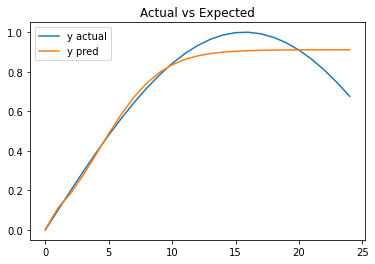

parameters 
 {'Wax': array([[2.44153161]]), 'Waa': array([[-0.14092471]]), 'Wya': array([[0.49279201]]), 'b': array([[-1.09257478]]), 'by': array([[0.41827476]])} 

final gradients 
 {'dWaa': array([[0.00091566]]), 'dWax': array([[-0.00280607]]), 'dWya': array([[0.00022204]]), 'db': array([[0.00201676]]), 'dby': array([[-0.00020817]])} 



In [0]:
parameters = model(X, Y, num_iterations=20000, n_a=1, learning_rate=0.01, print_chart=True)

Iteration: 0, Loss: 14.714538
Iteration: 1000, Loss: 0.171223
Iteration: 2000, Loss: 0.167507
Iteration: 3000, Loss: 0.164070
Iteration: 4000, Loss: 0.160806
Iteration: 5000, Loss: 0.157921
Iteration: 6000, Loss: 0.155493
Iteration: 7000, Loss: 0.153504
Iteration: 8000, Loss: 0.151888
Iteration: 9000, Loss: 0.150573
Iteration: 10000, Loss: 0.149495
Iteration: 11000, Loss: 0.148600
Iteration: 12000, Loss: 0.147849
Iteration: 13000, Loss: 0.147210
Iteration: 14000, Loss: 0.146662
Iteration: 15000, Loss: 0.146185
Iteration: 16000, Loss: 0.145767
Iteration: 17000, Loss: 0.145396
Iteration: 18000, Loss: 0.145065
Iteration: 19000, Loss: 0.144767



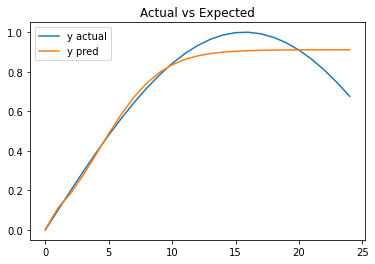

parameters 
 {'Wax': array([[2.44153161]]), 'Waa': array([[-0.14092471]]), 'Wya': array([[0.49279201]]), 'b': array([[-1.09257478]]), 'by': array([[0.41827476]])} 

final gradients 
 {'dWaa': array([[0.00091566]]), 'dWax': array([[-0.00280607]]), 'dWya': array([[0.00022204]]), 'db': array([[0.00201676]]), 'dby': array([[-0.00020817]])} 



In [0]:
parameters = model(X, Y, num_iterations=20000, n_a=1, learning_rate=0.01, print_chart=True)

Iteration: 0, Loss: 14.693690
Iteration: 1000, Loss: 0.183217
Iteration: 2000, Loss: 0.122519
Iteration: 3000, Loss: 0.067011
Iteration: 4000, Loss: 0.030455
Iteration: 5000, Loss: 0.014656
Iteration: 6000, Loss: 0.008816
Iteration: 7000, Loss: 0.006423
Iteration: 8000, Loss: 0.005177
Iteration: 9000, Loss: 0.004366
Iteration: 10000, Loss: 0.003763
Iteration: 11000, Loss: 0.003283
Iteration: 12000, Loss: 0.002887
Iteration: 13000, Loss: 0.002553
Iteration: 14000, Loss: 0.002267
Iteration: 15000, Loss: 0.002020
Iteration: 16000, Loss: 0.001804
Iteration: 17000, Loss: 0.001616
Iteration: 18000, Loss: 0.001450
Iteration: 19000, Loss: 0.001304



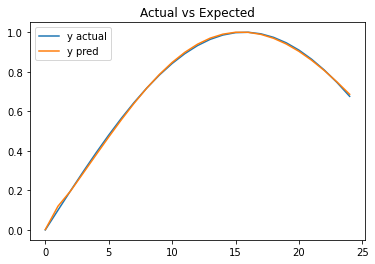

parameters 
 {'Wax': array([[ 1.27592187],
       [-0.46356214]]), 'Waa': array([[-0.25904032, -0.19067935],
       [ 0.44975041,  0.44969142]]), 'Wya': array([[0.90791755, 0.88015586]]), 'b': array([[-0.3505144],
       [ 0.6349382]]), 'by': array([[-0.20434693]])} 

final gradients 
 {'dWaa': array([[-5.72014116e-05,  1.02449533e-03],
       [-1.16994797e-03, -1.21566523e-03]]), 'dWax': array([[0.00023797],
       [0.00049813]]), 'dWya': array([[9.05835827e-05, 5.84280374e-04]]), 'db': array([[-0.00210678],
       [-0.00085814]]), 'dby': array([[0.00169783]])} 



In [0]:
parameters = model(X, Y, num_iterations=20000, n_a=2, learning_rate=0.005, print_chart=True)

Iteration: 0, Loss: 14.714762
Iteration: 1000, Loss: 0.144306
Iteration: 2000, Loss: 0.039127
Iteration: 3000, Loss: 0.006697
Iteration: 4000, Loss: 0.003492
Iteration: 5000, Loss: 0.002626
Iteration: 6000, Loss: 0.002068
Iteration: 7000, Loss: 0.001665
Iteration: 8000, Loss: 0.001278
Iteration: 9000, Loss: 0.001007
Iteration: 10000, Loss: 0.000793
Iteration: 11000, Loss: 0.000626
Iteration: 12000, Loss: 0.000494
Iteration: 13000, Loss: 0.000391
Iteration: 14000, Loss: 0.000310
Iteration: 15000, Loss: 0.000247
Iteration: 16000, Loss: 0.000198
Iteration: 17000, Loss: 0.000160
Iteration: 18000, Loss: 0.000130
Iteration: 19000, Loss: 0.000107



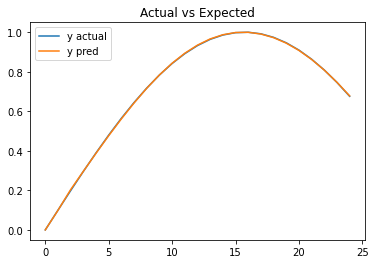

parameters 
 {'Wax': array([[ 1.34900226],
       [-0.73685611],
       [-0.4994763 ]]), 'Waa': array([[-0.21765679,  0.28730629, -0.0732076 ],
       [-0.07539149,  0.1020431 ,  0.05685462],
       [ 0.55213335, -0.19226929,  0.46312225]]), 'Wya': array([[0.86601963, 0.02575513, 0.94937045]]), 'b': array([[-0.30366034],
       [ 0.07215076],
       [ 0.48521089]]), 'by': array([[-0.22898916]])} 

final gradients 
 {'dWaa': array([[ 2.40279097e-05, -1.63424969e-05, -3.74645604e-05],
       [-2.22193379e-04, -1.04199754e-04,  1.11919808e-05],
       [-4.52189003e-04,  1.78634284e-04, -4.38768097e-04]]), 'dWax': array([[ 6.44317945e-05],
       [-1.40408501e-04],
       [ 1.63109887e-04]]), 'dWya': array([[ 1.26481732e-04, -1.96021131e-05,  5.73347769e-06]]), 'db': array([[-1.81034597e-04],
       [-3.07667876e-04],
       [ 2.00723805e-05]]), 'dby': array([[0.00037942]])} 



In [0]:
parameters = model(X, Y, num_iterations=20000, n_a=3, learning_rate=0.01, print_chart=True)

Iteration: 0, Loss: 14.711017
Iteration: 1000, Loss: 0.109919
Iteration: 2000, Loss: 0.026315
Iteration: 3000, Loss: 0.008316
Iteration: 4000, Loss: 0.004150
Iteration: 5000, Loss: 0.003061
Iteration: 6000, Loss: 0.002544
Iteration: 7000, Loss: 0.002255
Iteration: 8000, Loss: 0.001981
Iteration: 9000, Loss: 0.001961
Iteration: 10000, Loss: 0.004137
Iteration: 11000, Loss: 0.002677
Iteration: 12000, Loss: 0.002578
Iteration: 13000, Loss: 0.002333
Iteration: 14000, Loss: 0.002058
Iteration: 15000, Loss: 0.001870
Iteration: 16000, Loss: 0.001792
Iteration: 17000, Loss: 0.001729
Iteration: 18000, Loss: 0.001560
Iteration: 19000, Loss: 0.001405



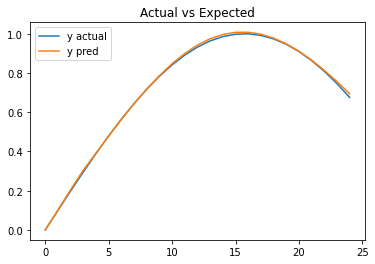

parameters 
 {'Wax': array([[-0.17454054],
       [ 0.0927642 ],
       [-0.44468594],
       [-1.23478744],
       [-0.21025144]]), 'Waa': array([[ 0.04409161,  0.01661015,  0.11811653,  0.01918145,  0.12175007],
       [ 0.00788561, -0.04766717, -0.14583815, -0.0353004 , -0.04508955],
       [ 0.04610394, -0.01213417,  0.27898948, -0.64756391,  0.13394461],
       [-0.01548638, -0.05562032,  0.14312726, -0.3286391 , -0.05607384],
       [ 0.12827181, -0.05774572,  0.04993925, -0.06394231,  0.17399315]]), 'Wya': array([[ 0.3144561 , -0.15239749,  0.86008963, -1.02160919,  0.3852175 ]]), 'b': array([[0.00457372],
       [0.04746183],
       [0.52861255],
       [0.45636914],
       [0.12039091]]), 'by': array([[0.01697556]])} 

final gradients 
 {'dWaa': array([[ 0.01234787, -0.00792215, -0.02134841,  0.03511974,  0.00899256],
       [-0.00489345,  0.00307992,  0.00707829, -0.01358847, -0.00382842],
       [ 0.03315268, -0.02093335, -0.04760496,  0.09245148,  0.02585993],
       [-0.01

In [0]:
parameters = model(X, Y, num_iterations=20000, n_a=5, learning_rate=0.01, print_chart=True)

Iteration: 0, Loss: 14.696445
Iteration: 1000, Loss: 0.086430
Iteration: 2000, Loss: 0.019726
Iteration: 3000, Loss: 0.006608
Iteration: 4000, Loss: 0.003320
Iteration: 5000, Loss: 0.002745
Iteration: 6000, Loss: 0.002329
Iteration: 7000, Loss: 0.001998
Iteration: 8000, Loss: 0.021521
Iteration: 9000, Loss: 0.001552
Iteration: 10000, Loss: 0.001451
Iteration: 11000, Loss: 0.001542
Iteration: 12000, Loss: 0.001876
Iteration: 13000, Loss: 0.002222
Iteration: 14000, Loss: 0.002249
Iteration: 15000, Loss: 0.002084
Iteration: 16000, Loss: 0.001901
Iteration: 17000, Loss: 0.001767
Iteration: 18000, Loss: 0.001701
Iteration: 19000, Loss: 0.001673



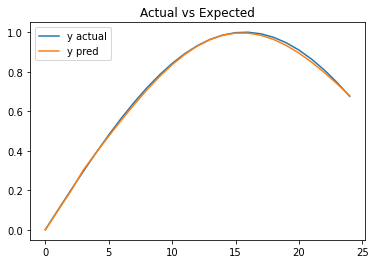

parameters 
 {'Wax': array([[ 0.15749538],
       [ 0.08333831],
       [-0.16147232],
       [-0.36304332],
       [-0.21500392],
       [-1.2106346 ],
       [-0.18131863],
       [-0.37101972],
       [-0.2373126 ],
       [ 0.03375382]]), 'Waa': array([[ 4.67442515e-02,  5.89357999e-03, -3.78982333e-02,
        -2.84659280e-02, -2.38380687e-02,  6.88090100e-02,
        -4.18804141e-02, -4.81021885e-02, -2.66939910e-02,
         9.08562320e-03],
       [ 1.65782410e-02,  3.44798057e-02, -1.67502086e-02,
        -2.91151567e-04, -4.85262077e-03,  1.16739309e-02,
        -1.81532924e-02, -8.03326926e-02, -4.01298320e-03,
         7.91322359e-03],
       [-4.07717770e-02, -2.67374708e-02,  2.45065159e-02,
         4.05868826e-02,  2.24503425e-02, -5.80672133e-02,
         1.60395382e-02,  6.83906906e-02,  3.76408707e-02,
         1.70048190e-03],
       [-3.69427671e-02, -2.33464121e-02,  2.87067761e-02,
         1.91209438e-01,  7.97606481e-02, -4.78561613e-01,
         7.81185869e-02

In [0]:
parameters = model(X, Y, num_iterations=20000, n_a=10, learning_rate=0.01, print_chart=True)

### 2. Models with with m > 1

In [0]:
T_x = 25
m = 100

X = np.zeros((T_x, m))

for col in range(X.shape[1]):
  r = np.random.randint(1, 20)
  #r = 1
  X[:, col] = [x for x in range(r, r + T_x)]

# X = X/X.max()

Y = np.sin(X)

X.shape

(25, 100)

In [0]:
X[:, 0]

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.])

In [0]:
Y[:, 0]

array([1.79175947, 1.94591015, 2.07944154, 2.19722458, 2.30258509,
       2.39789527, 2.48490665, 2.56494936, 2.63905733, 2.7080502 ,
       2.77258872, 2.83321334, 2.89037176, 2.94443898, 2.99573227,
       3.04452244, 3.09104245, 3.13549422, 3.17805383, 3.21887582,
       3.25809654, 3.29583687, 3.33220451, 3.36729583, 3.40119738])

<font color='Red'> **IS IT CALCULATING THE LOSS CORRECTLY? h hat(t) - y(t)??? Are the gradients updating correctly?** </font>

Iteration: 0, Loss: 1249.988580
Iteration: 10000, Loss: 1249.785765
Iteration: 20000, Loss: 1249.802384
Iteration: 30000, Loss: 1249.791126
Iteration: 40000, Loss: 1249.773060
Iteration: 50000, Loss: 1249.729201
Iteration: 60000, Loss: 1249.772406
Iteration: 70000, Loss: 1249.801804
Iteration: 80000, Loss: 1249.757708
Iteration: 90000, Loss: 1249.710356



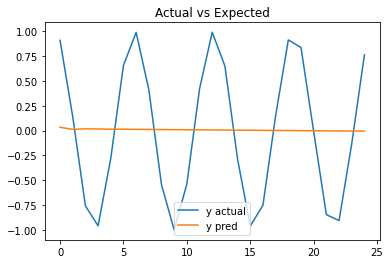

parameters 
 {'Wax': array([[ 0.01065172],
       [-0.03663941],
       [-0.02245572]]), 'Waa': array([[-0.32389181,  0.02251349,  0.65270636],
       [-0.00195547, -0.33590098, -0.12094758],
       [-0.28589488,  0.07583795, -0.65106074]]), 'Wya': array([[-0.00916411, -0.00264344,  0.07332747]]), 'b': array([[ 1.00164296],
       [-0.17455966],
       [ 0.38361933]]), 'by': array([[0.01948563]])} 

final gradients 
 {'dWaa': array([[ 1.16921006, -4.64447869, -2.84781553],
       [-0.24514327,  0.78745871,  0.55176049],
       [-1.77299735,  1.8374505 , -2.76957529]]), 'dWax': array([[-0.86013677],
       [-2.34375831],
       [ 5.        ]]), 'dWya': array([[ 0.47125358, -0.34109371,  0.12850572]]), 'db': array([[ 2.44593227],
       [-0.3141679 ],
       [-5.        ]]), 'dby': array([[0.00184275]])} 



In [0]:
parameters = model(X, Y, num_iterations=100000, n_a=3, learning_rate=0.00001, print_chart=True, grad_max=5, print_grad_updates=False, update_n=10000)

In [0]:
 

da = np.array([[-0.00415789,  0.00181396], [-0.00415789,  0.00181396]])
a =  np.array([[ 0.04700742], [-0.0169694 ]])
daraw_og = np.array([[-0.0041487,   0.00180995], [-0.00415669,  0.00181343]])

daraw_check

print(da)
print(a)
print(daraw_og)



NameError: ignored

In [0]:
np.dot(da, (1 - a * a))

array([[-0.00233526],
       [-0.00233526]])

In [0]:
da * (1 - a * a)

array([[-0.0041487 ,  0.00180995],
       [-0.00415669,  0.00181344]])

In [0]:
m# STILL NEED TO UNDERSTAND THIS BIT
dy = np.copy(y_hat[t])
dy[Y[t]] -= 1

In [0]:
dy = 10

In [0]:
y = [3

In [0]:
Y = []
Y.append(3)
Y.append(4)

In [0]:
Y

[3, 4]

In [0]:
y[Y[0]]

TypeError: ignored

In [0]:
    x, a, y_hat = {}, {}, {}

    a0 = 100
    
    a[-1] = np.copy(a0)

In [0]:
a

{-1: array(100)}